In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.models import Sequential

In [2]:
# sonnets.txt
!gdown --id 108jAePKK4R3BVYBbYJZ32JWUwxeMg20K

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=108jAePKK4R3BVYBbYJZ32JWUwxeMg20K
To: /content/sonnets.txt
100% 93.6k/93.6k [00:00<00:00, 92.8MB/s]


In [3]:
path = "/content/sonnets.txt"

with open(path, "r") as f:
  data = f.read()

In [4]:
data

"FROM fairest creatures we desire increase,\nThat thereby beauty's rose might never die,\nBut as the riper should by time decease,\nHis tender heir might bear his memory:\nBut thou, contracted to thine own bright eyes,\nFeed'st thy light'st flame with self-substantial fuel,\nMaking a famine where abundance lies,\nThyself thy foe, to thy sweet self too cruel.\nThou that art now the world's fresh ornament\nAnd only herald to the gaudy spring,\nWithin thine own bud buriest thy content\nAnd, tender churl, makest waste in niggarding.\nPity the world, or else this glutton be,\nTo eat the world's due, by the grave and thee.\nWhen forty winters shall beseige thy brow,\nAnd dig deep trenches in thy beauty's field,\nThy youth's proud livery, so gazed on now,\nWill be a tatter'd weed, of small worth held:\nThen being ask'd where all thy beauty lies,\nWhere all the treasure of thy lusty days,\nTo say, within thine own deep-sunken eyes,\nWere an all-eating shame and thriftless praise.\nHow much mor

In [5]:
corpus = data.lower().split("\n")
len(corpus)

2159

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

In [7]:
corpus[0]

'from fairest creatures we desire increase,'

In [8]:
# tokenizer.texts_to_sequences(corpus[0]) -> unexpected output result
# tokenizer.texts_to_sequences([corpus[0]]) -> list of list we want
tokenizer.texts_to_sequences([corpus[0]])[0] # what we want: list of tokens

[34, 417, 877, 166, 213, 517]

In [9]:
def n_gram_sequences(corpus, tokenizer):
  input_seqs = []
  for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
      n_gram_seq = token_list[:i+1]
      input_seqs.append(n_gram_seq)  
  return input_seqs

In [10]:
ex = n_gram_sequences([corpus[0]], tokenizer)
ex

[[34, 417],
 [34, 417, 877],
 [34, 417, 877, 166],
 [34, 417, 877, 166, 213],
 [34, 417, 877, 166, 213, 517]]

In [11]:
len(ex)

5

In [12]:
def pad_seqs(input_seq, maxlen_):
  padded_seq = np.array(pad_sequences(input_seq, maxlen=maxlen_, padding="pre"))
  return padded_seq

In [13]:
padded_seqs = pad_seqs(ex, len(ex))
padded_seqs

array([[  0,   0,   0,  34, 417],
       [  0,   0,  34, 417, 877],
       [  0,  34, 417, 877, 166],
       [ 34, 417, 877, 166, 213],
       [417, 877, 166, 213, 517]], dtype=int32)

In [14]:
input_seqs = n_gram_sequences(corpus, tokenizer)

In [15]:
max_len = max([len(x) for x in input_seqs])
max_len

11

In [16]:
padded_seqs = pad_seqs(input_seqs, max_len)
padded_seqs.shape

(15462, 11)

In [17]:
def split_features_labels(input_seq, total_words):
  features = input_seq[:, :-1]
  labels = input_seq[:, -1]
  one_hot_labels = to_categorical(labels, num_classes=total_words)

  return features, one_hot_labels

In [18]:
features, labels = split_features_labels(padded_seqs, total_words)

In [19]:
features.shape, labels.shape

((15462, 10), (15462, 3211))

In [25]:
def create_model():
  model = Sequential([
      Embedding(total_words, 128, input_length=max_len-1),
      Bidirectional(LSTM(256, return_sequences=True)),
      Dropout(0.1),
      Bidirectional(LSTM(128, return_sequences=True)),
      Dropout(0.1),
      Bidirectional(LSTM(128)),
      Dense(64, activation="relu"),
      Dense(total_words, activation="softmax")
  ])

  model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
  print(model.summary())

  return model

In [26]:
model = create_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10, 128)           411008    
                                                                 
 bidirectional_3 (Bidirectio  (None, 10, 512)          788480    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 10, 512)           0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 10, 256)          656384    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 10, 256)           0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 256)             

In [28]:
history = model.fit(features, labels, epochs=1000, verbose=1)

Epoch 1/1000
484/484 [==============================] - 7s 14ms/step - loss: 5.8812 - accuracy: 0.0378
Epoch 2/1000
484/484 [==============================] - 7s 14ms/step - loss: 5.8236 - accuracy: 0.0416
Epoch 3/1000
484/484 [==============================] - 7s 14ms/step - loss: 5.7723 - accuracy: 0.0439
Epoch 4/1000
484/484 [==============================] - 7s 14ms/step - loss: 5.7164 - accuracy: 0.0454
Epoch 5/1000
484/484 [==============================] - 7s 14ms/step - loss: 5.6539 - accuracy: 0.0495
Epoch 6/1000
484/484 [==============================] - 7s 14ms/step - loss: 5.5964 - accuracy: 0.0534
Epoch 7/1000
484/484 [==============================] - 7s 15ms/step - loss: 5.5492 - accuracy: 0.0543
Epoch 8/1000
484/484 [==============================] - 7s 15ms/step - loss: 5.4956 - accuracy: 0.0597
Epoch 9/1000
484/484 [==============================] - 7s 14ms/step - loss: 5.4396 - accuracy: 0.0625
Epoch 10/1000
484/484 [==============================] - 7s 14ms/step - l

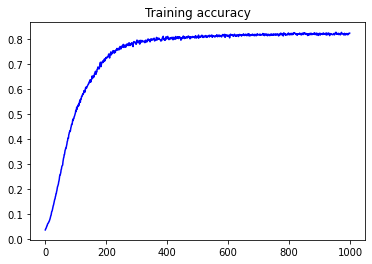

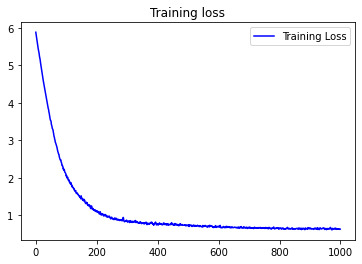

In [29]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [31]:
seed_text = "I fell in love with moon"
next_words = 20
  
for _ in range(next_words):
	# Convert the text into sequences
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	# Pad the sequences
	token_list = pad_sequences([token_list], maxlen=max_len-1, padding='pre')
	# Get the probabilities of predicting a word
	predicted = model.predict(token_list, verbose=0)
	# Choose the next word based on the maximum probability
	predicted = np.argmax(predicted, axis=-1).item()
	# Get the actual word from the word index
	output_word = tokenizer.index_word[predicted]
	# Append to the current text
	seed_text += " " + output_word

print(seed_text)

I fell in love with moon with thee and seem days ' be guest common autumn kill'd rehearse bright pass embassage groan than ' flatter'd be


In [32]:
model.save("lstm1000.h5")

In [34]:
m = tf.keras.models.load_model("/content/lstm1000.h5")
m.evaluate(features, labels)

484/484 [==============================] - 5s 7ms/step - loss: 0.4844 - accuracy: 0.8631


[0.4843742847442627, 0.8631483912467957]

In [43]:
tokenizer.index_word[np.argmax(m.predict(pad_sequences([tokenizer.texts_to_sequences(["one day we will be old"])[0]], maxlen=max_len-1, padding='pre')), axis=-1).item()]

'your'